<a href="https://colab.research.google.com/github/CAVASOL/aiffel_quest/blob/main/DLThon/jellyfish_conv_mixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 2. 라이브러리 호출

In [ ]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

IMG_SIZE = 40, 40
BATCH_SIZE = 32
SEED = 5
AUTO = tf.data.AUTOTUNE

## Step 3. 데이터 불러오기

In [ ]:
# Creating main dataframe contains image paths and their classes.

# 이미지 리스트 만드는 함수
def create_images_list(path):
    full_path = [] # return 하는 전체 경로
    images = os.listdir(path) # 입력 받은 폴더의 안의 모든 파일과 디렉터리 경로 리스트를 images에 할당
    for i in images: # 폴더 안의 모든 파일을 full_path 리스트에 추가
        full_path.append(os.path.join(path, i))

    return full_path

# 각각의 폴더 안의 이미지 파일 경로들을 각각의 해파리 리스트에 할당
data_moon = create_images_list('/content/drive/MyDrive/aiffel/Jellyfish/Moon_jellyfish')
data_barrel = create_images_list('/content/drive/MyDrive/aiffel/Jellyfish/barrel_jellyfish')
data_blue = create_images_list('/content/drive/MyDrive/aiffel/Jellyfish/blue_jellyfish')
data_compass = create_images_list('/content/drive/MyDrive/aiffel/Jellyfish/compass_jellyfish')
data_lions_mane = create_images_list('/content/drive/MyDrive/aiffel/Jellyfish/lions_mane_jellyfish')
data_mauve_stinger = create_images_list('/content/drive/MyDrive/aiffel/Jellyfish/mauve_stinger_jellyfish')

# 숫자 레이블을 해파리의 종류 이름으로 매핑
# 중복 불가
jellyfish_classes = {0:'Moon', 1 : 'Barrel', 2 : 'Blue', 3 : 'Compass', 4 : 'Lion’s mane', 5: 'Mauve stinger'}

# 각 해파리 종류별로 경로와 레이블을 포함하는 데이터프레임을 생성
# ignore_index=True 는 인덱스를 새로 지정한다.
data_df = pd.concat([pd.DataFrame({"img" : np.array(data_moon) , "label": 0 }),
                     pd.DataFrame({"img" : np.array(data_barrel) , "label": 1 }),
                     pd.DataFrame({"img" : np.array(data_blue) , "label": 2 }),
                     pd.DataFrame({"img" : np.array(data_compass) , "label": 3 }),
                     pd.DataFrame({"img" : np.array(data_lions_mane) , "label": 4 }),
                     pd.DataFrame({"img" : np.array(data_mauve_stinger) , "label": 5 }) ], ignore_index = True)

# data_df = shuffle(data_df, random_state = SEED) 는 데이터 프레임을 무작위로 섞어서
# 모델이 특정 순서에 의존하지 않도록 합니다,
# 'SEED'는 난수 생성 시드로, 실험의 재현성을 위해 사용됩니다.
data_df = shuffle(data_df, random_state = SEED).reset_index(drop = True)
# 데이터 프레임의 상위 5개 행을 출력
data_df.head()

,img,label
0,/content/drive/MyDrive/aiffel/Jellyfish/compas...,3
1,/content/drive/MyDrive/aiffel/Jellyfish/lions_...,4
2,/content/drive/MyDrive/aiffel/Jellyfish/mauve_...,5
3,/content/drive/MyDrive/aiffel/Jellyfish/mauve_...,5
4,/content/drive/MyDrive/aiffel/Jellyfish/Moon_j...,0


In [ ]:
# 900행 2열의 DataFrame
data_df.shape

(900, 2)

In [ ]:
# 결과값을 정수로 받기 위해 // 를 사용
# test 데이터는 train 데이터의 15%
test_idx = data_df.shape[0] * 15 // 100
test_idx

135

In [ ]:
# splitting into train_df (train and valid) and test_df
# data_df의 15%를 test 데이터로 따로 분리한다.

test_idx = data_df.shape[0] * 15 // 100

# reset_index() : 이 메서드는 DataFrame의 인덱스를 기본 정수 인덱스(0부터 시작하는)로 재설정합니다. 이 과정에서 기존 인덱스는 새로운 열로 추가됩니다.
# drop = True : 이 옵션을 사용하면 기존 인덱스를 DataFrame에서 제거합니다. 즉 기존 인덱스를 새로운 열로 추가하는 대신 완전히 버리고, 단순히 정수 인덱스로만 재설정합니다.
train_df = data_df[test_idx:].reset_index(drop = True)
test_df = data_df[:test_idx].reset_index(drop = True)


print("train_df (train and val) shape -> ", train_df.shape[0])
print("test_df shape -> ", test_df.shape[0])

train_df (train and val) shape ->  765
test_df shape ->  135


## Step 4. Cumtom ConvMixer Layer

In [ ]:
'''
이 코드는 케라스(Keras)를 사용하여 'ConvMixerBlock'이라는 사용자 정의 레이어를 정의하는 클래스입니다.
'ConvMixerBlock'은 컨볼루션 믹서(convolution mixer) 아키텍처의 한 부분으로 사용되며, 주로 딥러닝 모델에서 이미지 처리에 활용됩니다.
'''
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs): # 클래스 생성자이며 (filter, kernel_size, patch_size) 및 기타 키워드 인수(**kwargs)를 받습니다.
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size

        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)

        return X


    def get_config(self):
        base_config = super().get_config()

        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

## Step 5. 모델 제작

In [ ]:
FEATURES = 256
inp = Input(shape = (*IMG_SIZE, 3))

X = Conv2D(FEATURES, 2, 2)(inp)
X = Activation('relu')(X)
X = BatchNormalization()(X)

X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_1')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_2')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_3')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_4')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_5')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_6')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_7')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_8')(X)


X = GlobalAveragePooling2D()(X)
out = Dense(6, activation = 'softmax')(X)

model = Model(inputs = inp, outputs = out)
model.summary()

model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_acc", dtype=None) ] )


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 256)       3328      
                                                                 
 activation (Activation)     (None, 20, 20, 256)       0         
                                                                 
 batch_normalization (Batch  (None, 20, 20, 256)       1024      
 Normalization)                                                  
                                                                 
 CONVMIXER_1 (ConvMixerBloc  (None, 20, 20, 256)       74496     
 k)                                                              
                                                                 
 CONVMIXER_2 (ConvMixerBloc  (None, 20, 20, 256)       74496 

In [ ]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


# Basic data augmentation
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)

    return image, label

In [ ]:
# Creating test dataset loader and tf.dataset

test_loader = tf.data.Dataset.from_tensor_slices((test_df['img'], test_df['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

In [ ]:
fold_hists = []
test_evals = []
test_preds = []

EPOCHS = 20
FOLDS = 10

kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

for i, (train_index, val_index) in  enumerate(kf.split(train_df['img'], train_df['label'])):

    print('-'*90)
    print(str(i+1) + '.fold training')

    X_train_fold = train_df['img'][train_index]
    y_train_fold = train_df['label'][train_index]

    X_val_fold = train_df['img'][val_index]
    y_val_fold = train_df['label'][val_index]


    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls = AUTO)
                     .map(augmentation, num_parallel_calls = AUTO)
                     .batch(BATCH_SIZE)
                     .shuffle(BATCH_SIZE*5)
                     .prefetch(AUTO))

    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls = AUTO)
                          .batch(BATCH_SIZE)
                          .prefetch(AUTO))


    # Training
    hist = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = validation_dataset, verbose = 0)
    fold_hists.append(hist)

    # Test evaluation
    test_eval = model.evaluate(test_dataset)
    test_evals.append(test_eval)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    print('Test Sparse Top 2 Accuracy: {0:.2f} %'.format(test_eval[2]*100))

    # Test set prediction
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)

------------------------------------------------------------------------------------------
1.fold training
5/5 [==============================] - 12s 2s/step - loss: 3.8413 - acc: 0.1407 - top_3_acc: 0.5407
Test Loss: 3.841
Test Accuracy: 14.074 %
Test Sparse Top 2 Accuracy: 54.07 %
5/5 [==============================] - 1s 38ms/step
------------------------------------------------------------------------------------------
2.fold training
5/5 [==============================] - 0s 31ms/step - loss: 0.4393 - acc: 0.8593 - top_3_acc: 0.9778
Test Loss: 0.439
Test Accuracy: 85.926 %
Test Sparse Top 2 Accuracy: 97.78 %
5/5 [==============================] - 0s 34ms/step
------------------------------------------------------------------------------------------
3.fold training
5/5 [==============================] - 0s 32ms/step - loss: 0.3220 - acc: 0.8667 - top_3_acc: 1.0000
Test Loss: 0.322
Test Accuracy: 86.667 %
Test Sparse Top 2 Accuracy: 100.00 %
5/5 [==============================] - 0s

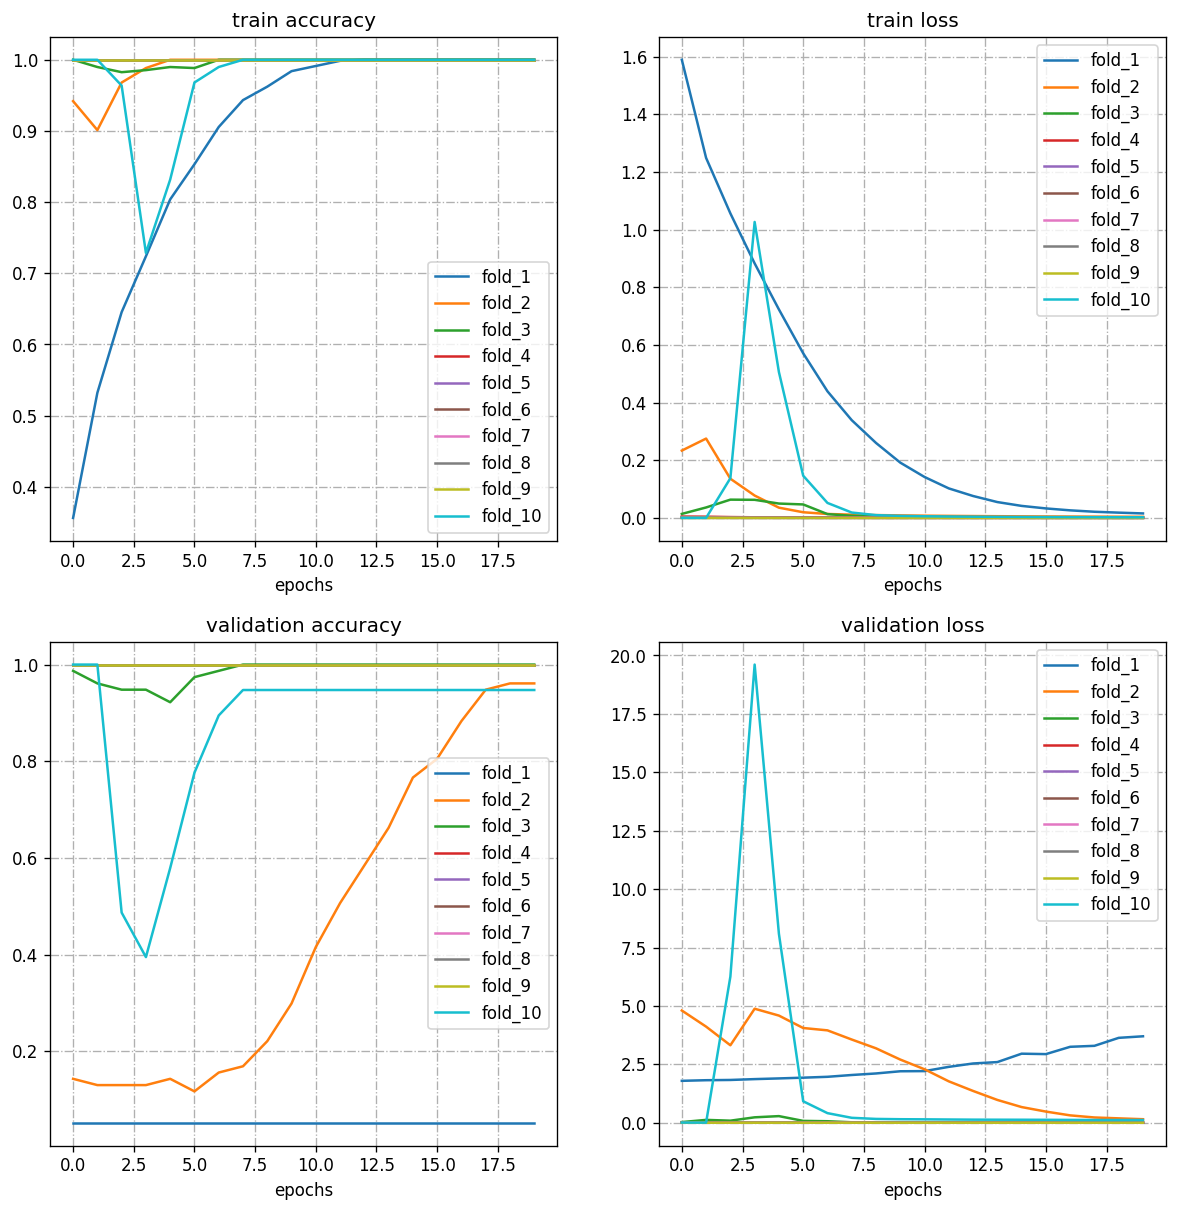

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []

axs[0][0].set_title('train accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][0].plot(fold_hists[i].history['acc'])
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(folds_name, fontsize = 10)


axs[0][1].set_title('train loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][1].plot(fold_hists[i].history['loss'])
axs[0][1].legend(folds_name, fontsize = 10)


axs[1][0].set_title('validation accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][0].plot(fold_hists[i].history['val_acc'])
axs[1][0].legend(folds_name, fontsize = 10)


axs[1][1].set_title('validation loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][1].plot(fold_hists[i].history['val_loss'])
axs[1][1].legend(folds_name, fontsize = 10)


In [ ]:
# Calculating the mean of 10 folds predictions

preds = np.mean(test_preds, axis = 0)
last_pred = np.argmax(preds, axis = 1)

In [ ]:
clf = classification_report(test_df['label'] , last_pred, target_names = list(jellyfish_classes.values()))
print(clf)

               precision    recall  f1-score   support

         Moon       0.75      0.94      0.83        16
       Barrel       0.95      0.95      0.95        19
         Blue       0.93      0.82      0.87        33
      Compass       0.83      0.95      0.89        21
  Lion’s mane       0.75      0.75      0.75        16
Mauve stinger       0.96      0.87      0.91        30

     accuracy                           0.87       135
    macro avg       0.86      0.88      0.87       135
 weighted avg       0.88      0.87      0.87       135



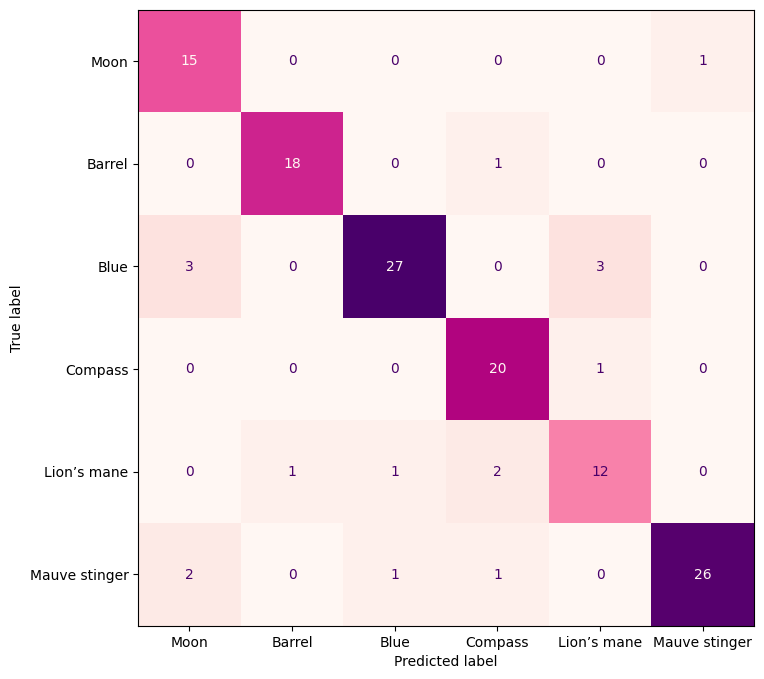

In [ ]:
cm = confusion_matrix(test_df['label'] , last_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(jellyfish_classes.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax,  cmap = 'RdPu', colorbar = False)

In [ ]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(last_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()


        if int(last_pred[idx[i]]) == label:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + jellyfish_classes[label], fontsize = 8, color = 'red')


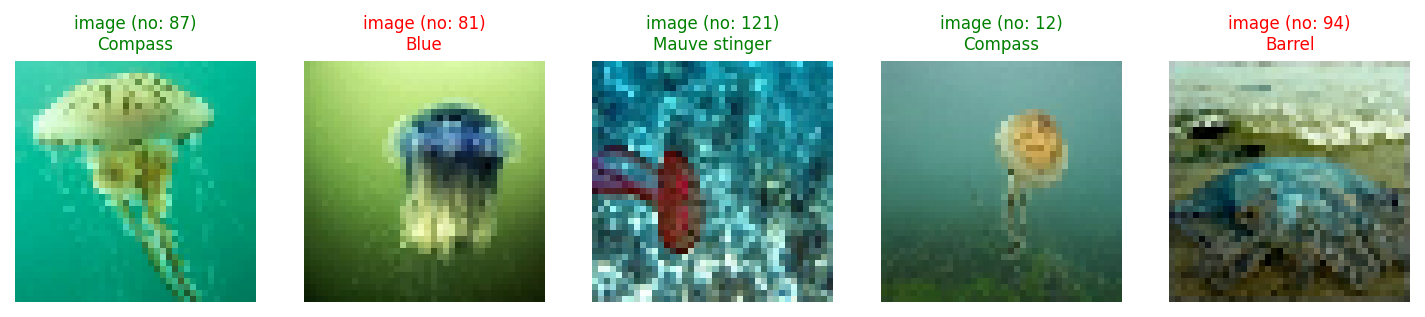

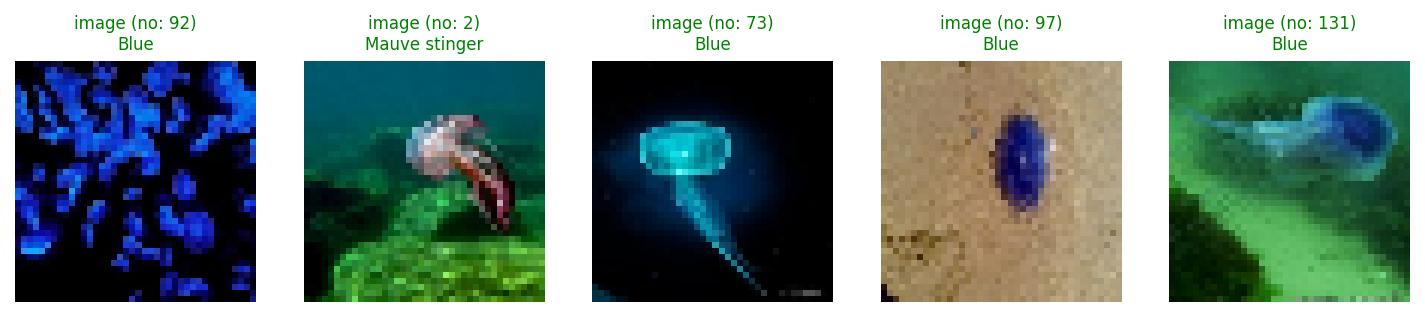

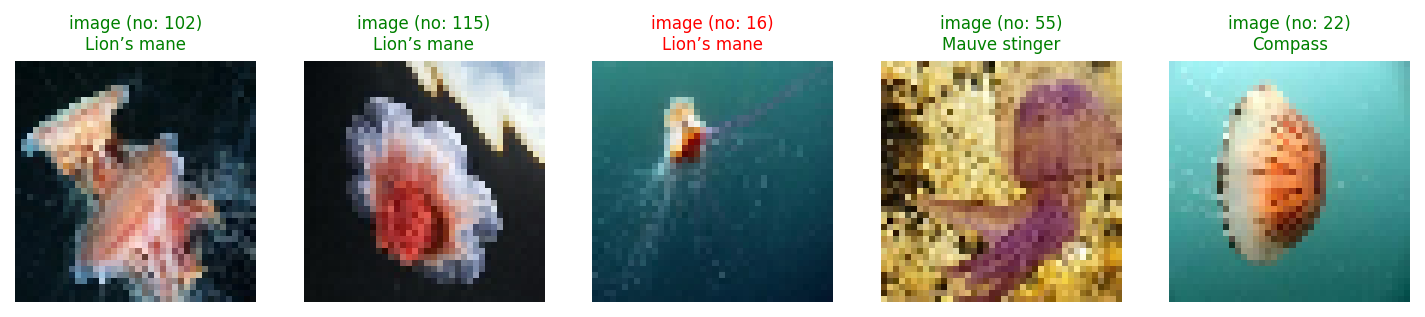

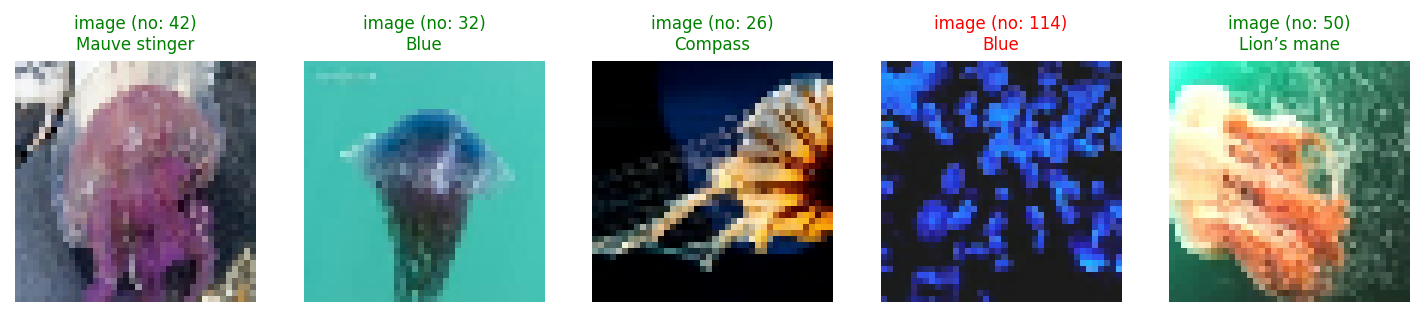

In [ ]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 145)
random_test_sample_with_prediction(SEED = 7)
random_test_sample_with_prediction(SEED = 78)
random_test_sample_with_prediction(SEED = 98)